### 데이터 불러오기

In [132]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

In [133]:
# train, test 데이터를 불러옵니다.
path = '/Users/yniyunj/Desktop/AI/250115-EVpriceprediction'
train = pd.read_csv(path + '/open/train.csv')
test = pd.read_csv(path + '/open/test.csv')

In [134]:
# 한글 폰트 파일 경로 지정
font_path = "/Users/yniyunj/Library/Fonts/NanumGothic-Regular.ttf"  # 설치된 폰트 경로
font_prop = font_manager.FontProperties(fname=font_path)

# Matplotlib 설정
rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("현재 설정된 폰트:", plt.rcParams['font.family'])

현재 설정된 폰트: ['NanumGothic']


In [135]:
train

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02
...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H사,ION5,Brand New,NaN,AWD,3773,10,No,0,35.95
7493,TRAIN_7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40
7494,TRAIN_7494,P사,TayCT,Brand New,NaN,AWD,1363,2,No,0,120.00
7495,TRAIN_7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00


### 데이터 살펴보기

- 배터리용량 결측치가 2711개다.

In [136]:
# 각 열의 결측치가 아닌 값 개수와 결측치 개수 출력
non_missing_values_count_train = train.notnull().sum()

for column, count in non_missing_values_count_train.items():
    missing_count = len(train) - count  # 전체 개수에서 결측치가 아닌 값 개수 차감
    print(f"{column}: {count} | 결측치 {missing_count}개")

ID: 7497 | 결측치 0개
제조사: 7497 | 결측치 0개
모델: 7497 | 결측치 0개
차량상태: 7497 | 결측치 0개
배터리용량: 4786 | 결측치 2711개
구동방식: 7497 | 결측치 0개
주행거리(km): 7497 | 결측치 0개
보증기간(년): 7497 | 결측치 0개
사고이력: 7497 | 결측치 0개
연식(년): 7497 | 결측치 0개
가격(백만원): 7497 | 결측치 0개


In [137]:
# 각 열의 결측치가 아닌 값 개수와 결측치 개수 출력
non_missing_values_count_test = test.notnull().sum()

for column, count in non_missing_values_count_test.items():
    missing_count = len(test) - count  # 전체 개수에서 결측치가 아닌 값 개수 차감
    print(f"{column}: {count} | 결측치 {missing_count}개")

ID: 846 | 결측치 0개
제조사: 846 | 결측치 0개
모델: 846 | 결측치 0개
차량상태: 846 | 결측치 0개
배터리용량: 542 | 결측치 304개
구동방식: 846 | 결측치 0개
주행거리(km): 846 | 결측치 0개
보증기간(년): 846 | 결측치 0개
사고이력: 846 | 결측치 0개
연식(년): 846 | 결측치 0개


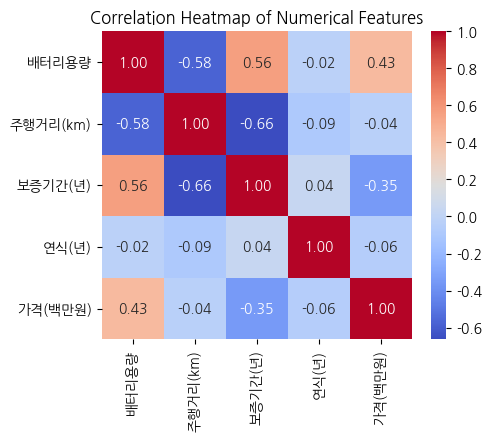

In [138]:
# 주요 숫자형 변수 선택
numerical_columns = ['배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)', '가격(백만원)']
categorical_columns = ['제조사', '모델', '차량상태', '구동방식', '사고이력']

# 상관계수 행렬 계산
correlation_matrix = train[numerical_columns].corr()

# 히트맵 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

- 모델별 가격: 0.99
- 모델과 제조사: 0.91
- 제조사와 가격: 0.90 

  제조사                     모델 목록  평균 가격(백만원)
0  P사      [TayGTS, TayCT, Tay]  131.990934
1  A사        [eT, RSeTGT, Q4eT]   75.128354
2  T사          [MS, MY, MX, M3]   70.153724
3  B사              [i5, iX, i3]   55.212344
4  V사                     [ID4]   38.411702
5  H사  [ION6, IONIQ, KNE, ION5]   31.312991
6  K사         [Niro, Soul, EV6]   30.779029


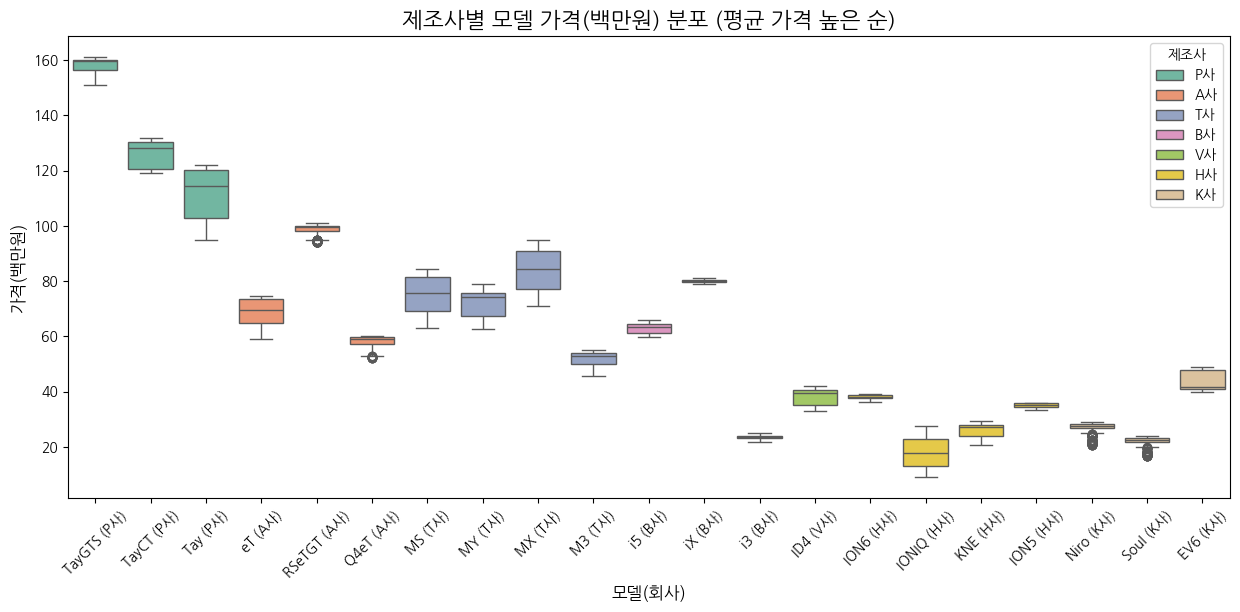

In [139]:
# 제조사별 고유 모델 추출 및 평균 가격 계산
manufacturer_models = train.groupby('제조사')['모델'].unique()
manufacturer_avg_price = train.groupby('제조사')['가격(백만원)'].mean()

# 두 데이터를 병합하여 하나의 데이터프레임으로 결합
manufacturer_summary = pd.DataFrame({'모델 목록': manufacturer_models, '평균 가격(백만원)': manufacturer_avg_price}).reset_index()

# 평균 가격을 기준으로 정렬
manufacturer_summary = manufacturer_summary.sort_values(by='평균 가격(백만원)', ascending=False).reset_index(drop=True)
print(manufacturer_summary)

# 회사별 순서를 평균 가격이 높은 순으로 정렬
manufacturer_order = manufacturer_summary['제조사'].tolist()

# 모델(회사) 형식으로 새로운 열 생성
train['모델(회사)'] = train['모델'] + " (" + train['제조사'] + ")"

# 모델(회사) 순서를 정렬
model_order = train.set_index('제조사').loc[manufacturer_order]['모델(회사)'].unique()

# 박스 플롯 생성
plt.figure(figsize=(15, 6))
sns.boxplot(x='모델(회사)', y='가격(백만원)', hue='제조사', data=train, order=model_order, hue_order=manufacturer_order, palette='Set2')

# 그래프 꾸미기
plt.title("제조사별 모델 가격(백만원) 분포 (평균 가격 높은 순)", fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.xlabel("모델(회사)", fontsize=12)
plt.ylabel("가격(백만원)", fontsize=12)
plt.legend(title="제조사", loc="upper right", fontsize=10)

plt.show()


제조사: A사, 모델: ['eT', 'RSeTGT', 'Q4eT']
제조사: B사, 모델: ['i5', 'iX', 'i3']
제조사: H사, 모델: ['ION6', 'IONIQ', 'KNE', 'ION5']
제조사: K사, 모델: ['Niro', 'Soul', 'EV6']
제조사: P사, 모델: ['TayGTS', 'TayCT', 'Tay']
제조사: T사, 모델: ['MS', 'MY', 'MX', 'M3']
제조사: V사, 모델: ['ID4']


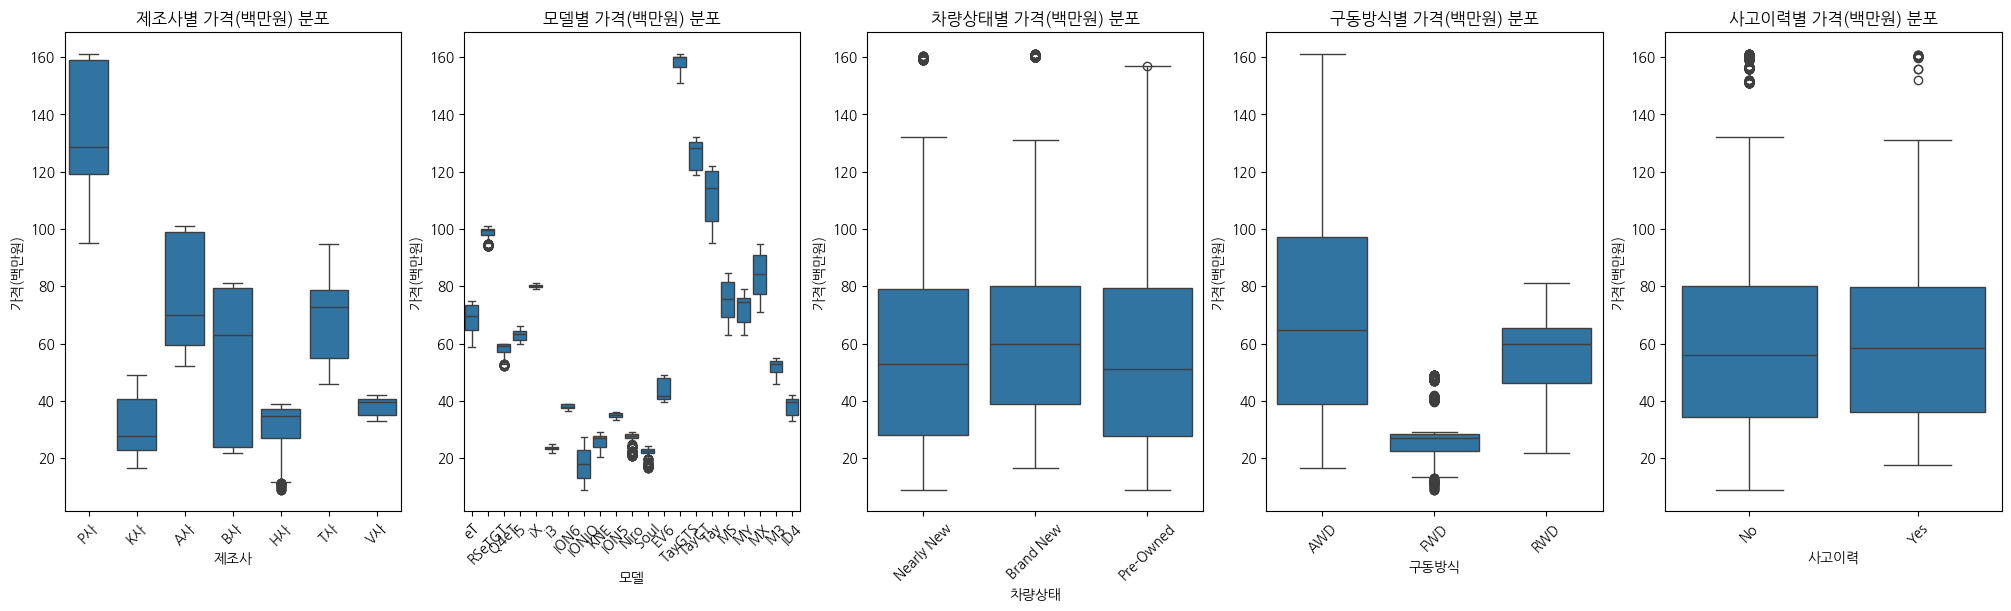

In [140]:
# 제조사별 고유 모델 추출
manufacturer_models = train.groupby('제조사')['모델'].unique()

# 데이터프레임으로 변환하여 보기 좋게 출력
manufacturer_models_df = manufacturer_models.reset_index()
manufacturer_models_df.columns = ['제조사', '모델 목록']

# 결과 확인
for index, row in manufacturer_models_df.iterrows():
    print(f"제조사: {row['제조사']}, 모델: {list(row['모델 목록'])}")

# 서브플롯 생성
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(20, 6), constrained_layout=True)

for i, col in enumerate(categorical_columns):
    if col == '모델':
        # 모델 순서를 제조사별로 정렬
        model_order = train.groupby('제조사')['모델'].apply(list).explode().unique()
        sns.boxplot(x=col, y='가격(백만원)', data=train, ax=axes[i], order=model_order)
    else:
        sns.boxplot(x=col, y='가격(백만원)', data=train, ax=axes[i])
    axes[i].set_title(f"{col}별 가격(백만원) 분포")
    axes[i].tick_params(axis='x', rotation=45)

plt.show()


In [141]:
print(train['제조사'].unique())
print(train['모델'].unique())
print(train['차량상태'].unique())
print(train['구동방식'].unique())
print(train['사고이력'].unique())

['P사' 'K사' 'A사' 'B사' 'H사' 'T사' 'V사']
['TayGTS' 'Niro' 'eT' 'RSeTGT' 'i5' 'ION6' 'MS' 'MY' 'Q4eT' 'ID4' 'TayCT'
 'Soul' 'iX' 'MX' 'IONIQ' 'EV6' 'KNE' 'M3' 'i3' 'ION5' 'Tay']
['Nearly New' 'Brand New' 'Pre-Owned']
['AWD' 'FWD' 'RWD']
['No' 'Yes']


### 인코딩하기

- 원핫인코딩: 모델, 차량상태, 구동방식 (제조사 제거)
- 라벨인코딩: 사고이력
- 제조사를 인코딩할 필요 없이, 모델만 인코딩해도 두 정보를 모두 포함한 것과 동일한 효과를 얻는다.
- 모델은 제조사와 이미 1:1 또는 1:N 관계를 가지고, 특정 모델이 어떤 제조사에 속하는지 이미 알려주기 때문이다.

In [142]:
# 데이터 복사
encoded_train = train.copy()

# 원-핫 인코딩 대상 변수 (제조사 제외)
one_hot_features = ['모델', '차량상태', '구동방식']

# 원-핫 인코더 초기화
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first'는 다중공선성 방지

# 원-핫 인코딩 적용
encoded_one_hot = pd.DataFrame(one_hot_encoder.fit_transform(encoded_train[one_hot_features]).astype(int),
                               columns=one_hot_encoder.get_feature_names_out(one_hot_features))

# 라벨 인코딩 대상 변수
label_encoder = LabelEncoder()

# '사고이력'에 라벨 인코딩 적용
encoded_train['사고이력'] = label_encoder.fit_transform(encoded_train['사고이력'])

# 원본 범주형 열 제거
encoded_train = encoded_train.drop(columns=one_hot_features)

# 인코딩된 열 병합
encoded_data = pd.concat([encoded_train, encoded_one_hot], axis=1)

# 결과 확인
print(encoded_data.head())

# CSV로 저장
encoded_data.to_csv(path + '/open/encoded_train.csv', index=False)

           ID 제조사   배터리용량  주행거리(km)  보증기간(년)  사고이력  연식(년)  가격(백만원)  \
0  TRAIN_0000  P사  86.077     13642        0     0      2   159.66   
1  TRAIN_0001  K사  56.000     10199        6     0      0    28.01   
2  TRAIN_0002  A사  91.200      2361        7     0      0    66.27   
3  TRAIN_0003  A사     NaN     21683        3     0      0    99.16   
4  TRAIN_0004  B사  61.018    178205        1     0      0    62.02   

        모델(회사)  모델_ID4  ...  모델_TayCT  모델_TayGTS  모델_eT  모델_i3  모델_i5  모델_iX  \
0  TayGTS (P사)       0  ...         0          1      0      0      0      0   
1    Niro (K사)       0  ...         0          0      0      0      0      0   
2      eT (A사)       0  ...         0          0      1      0      0      0   
3  RSeTGT (A사)       0  ...         0          0      0      0      0      0   
4      i5 (B사)       0  ...         0          0      0      0      1      0   

   차량상태_Nearly New  차량상태_Pre-Owned  구동방식_FWD  구동방식_RWD  
0                1               0       

### 배터리용량 결측값 채우기 위한 EDA

- 양의 상관관계:
    - 보증기간(년): 0.558 → 배터리 용량이 클수록 보증 기간이 길어질 가능성이 높음
    - 가격(백만원): 0.432 → 배터리 용량이 클수록 차량 가격이 높아질 가능성이 있음
- 음의 상관관계:
    - 주행거리(km): -0.577 → 배터리 용량이 클수록 차량 주행거리가 짧아질 가능성이 있음
    - 차량상태_Pre-Owned: -0.558 → 중고 차량일수록 배터리 용량이 작아질 가능성이 있음

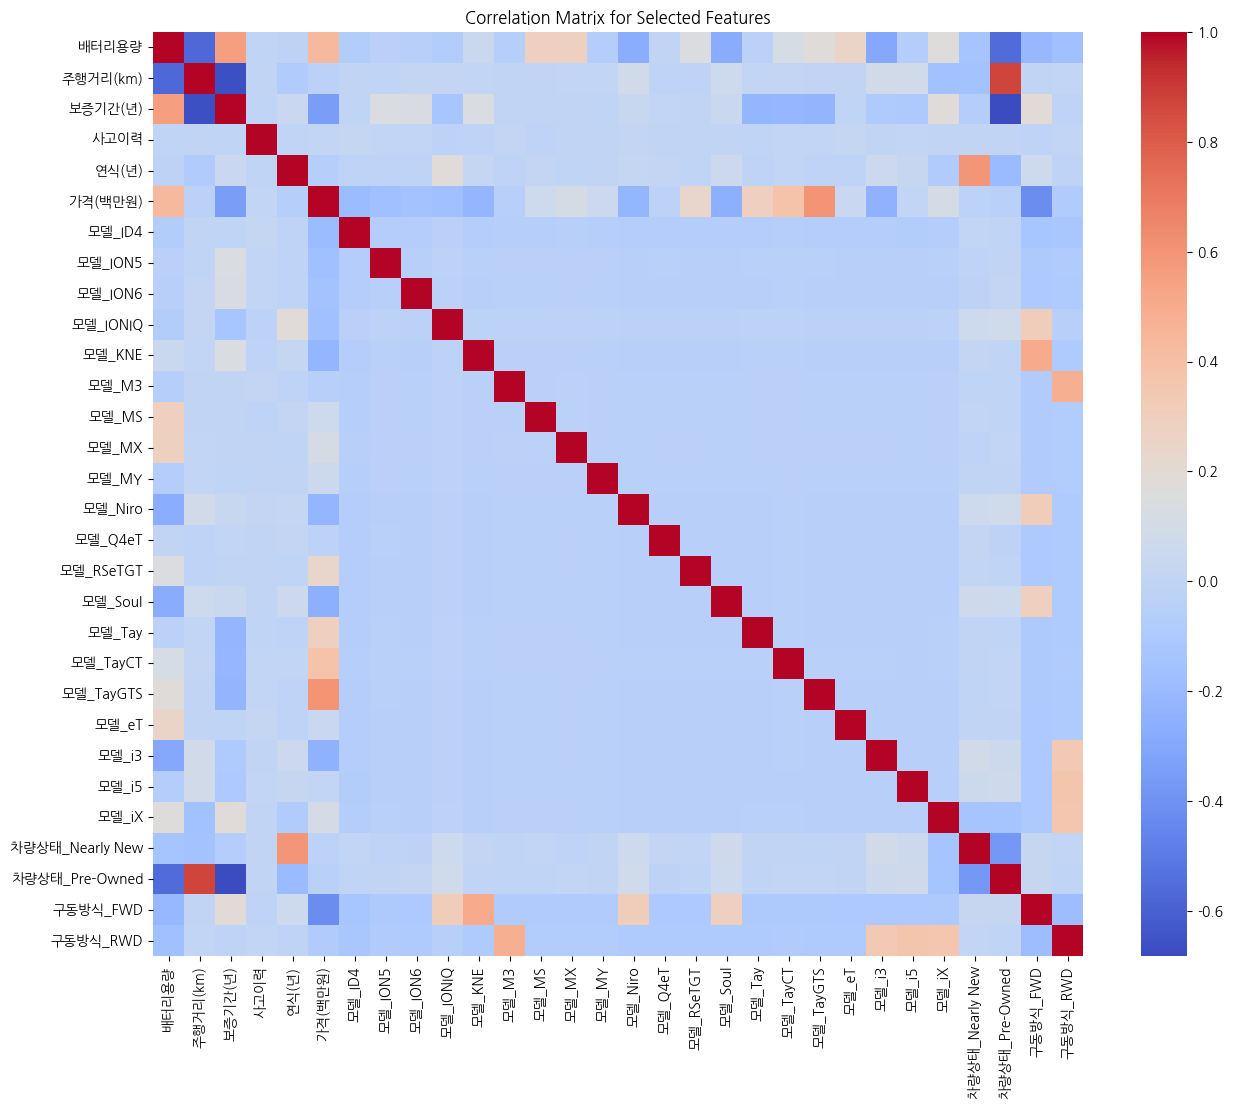

배터리용량과 다른 변수 간 상관관계:
배터리용량              1.000000
보증기간(년)            0.558242
가격(백만원)            0.431668
모델_MS              0.291915
모델_MX              0.285626
모델_eT              0.255226
모델_TayGTS          0.173061
모델_iX              0.171254
모델_RSeTGT          0.145588
모델_TayCT           0.113910
모델_KNE             0.041170
모델_Q4eT           -0.005217
사고이력              -0.009412
연식(년)             -0.021845
모델_Tay            -0.032409
모델_ION5           -0.042482
모델_ION6           -0.052345
모델_M3             -0.061524
모델_i5             -0.070081
모델_MY             -0.070694
모델_IONIQ          -0.073106
모델_ID4            -0.075798
차량상태_Nearly New   -0.136755
구동방식_RWD          -0.163465
구동방식_FWD          -0.212692
모델_Niro           -0.270262
모델_Soul           -0.278360
모델_i3             -0.296038
차량상태_Pre-Owned    -0.557873
주행거리(km)          -0.576538
Name: 배터리용량, dtype: float64


In [143]:
# 포함할 열만 선택
selected_columns = [
    '배터리용량', '주행거리(km)', '보증기간(년)', '사고이력', '연식(년)', '가격(백만원)',
    '모델_ID4', '모델_ION5', '모델_ION6', '모델_IONIQ', '모델_KNE', '모델_M3', '모델_MS', 
    '모델_MX', '모델_MY', '모델_Niro', '모델_Q4eT', '모델_RSeTGT', '모델_Soul', '모델_Tay', 
    '모델_TayCT', '모델_TayGTS', '모델_eT', '모델_i3', '모델_i5', '모델_iX',
    '차량상태_Nearly New', '차량상태_Pre-Owned', '구동방식_FWD', '구동방식_RWD'
]

# 선택된 열만 사용
filtered_data = encoded_data[selected_columns]

# 상관관계 계산
correlation_matrix = filtered_data.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix for Selected Features")
plt.show()

# 특정 변수와의 상관관계 (예: 배터리용량)
correlation_with_battery = correlation_matrix['배터리용량'].sort_values(ascending=False)
print("배터리용량과 다른 변수 간 상관관계:")
print(correlation_with_battery)

### Train 배터리 용량 결측값 채우기 (회귀모델 훈련)

- 배터리 용량을 목표 변수로 설정하고, 나머지 변수를 입력 변수로 사용해 회귀 모델을 훈련하여 결측치를 예측함
- KNN, RandomForest, LightGBM, XGBoost, CatBoost 모델 비교

In [144]:
# 결측값이 없는 데이터와 결측값이 있는 데이터 분리
train_data_no_na = encoded_data.dropna(subset=['배터리용량']).copy()
train_data_with_na = encoded_data[encoded_data['배터리용량'].isnull()].copy()


# 사용 변수 선택
features = ['보증기간(년)', '가격(백만원)', '주행거리(km)', '차량상태_Pre-Owned']

# 결측값이 없는 데이터 준비
X = train_data_no_na[features]
y = train_data_no_na['배터리용량']

# 결측값이 있는 데이터 준비
X_missing = train_data_with_na[features]

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

KNN RMSE: 8.436311408664725
RandomForest RMSE: 3.5535995419665456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 3828, number of used features: 4
[LightGBM] [Info] Start training from score 69.381099
LightGBM RMSE: 3.5136202048931495
XGBoost RMSE: 3.659094218218718
CatBoost RMSE: 3.615489400126327


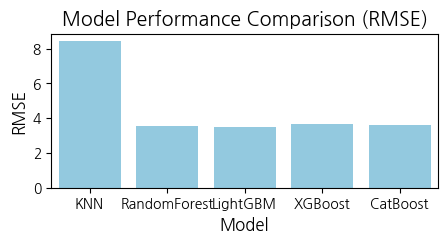

In [145]:
# 모델 리스트
models = {
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0)
}

# 결과 저장
model_performance = {}

# 모델 비교
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)  # RMSE 계산
    model_performance[name] = rmse
    print(f"{name} RMSE: {rmse}")

# 시각화
plt.figure(figsize=(5, 2))
sns.barplot(x=list(model_performance.keys()), y=list(model_performance.values()), color='skyblue')
plt.title("Model Performance Comparison (RMSE)", fontsize=14)
plt.ylabel("RMSE", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.show()

In [146]:
# 회귀 모델 초기화 및 훈련
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

# 검증 데이터로 모델 평가
y_pred = model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"검증 데이터 RMSE: {rmse}")

# 결측값 예측
train_data_with_na.loc[:, '배터리용량'] = model.predict(X_missing)

# 결측값이 채워진 데이터 결합
train_data_filled = pd.concat([train_data_no_na, train_data_with_na])

# 채워진 데이터 저장 (필요시)
train_data_filled.to_csv(path+'/open/encoded_train_filled.csv', index=False)
print("encoded_train_filled.csv에 저장되었습니다.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 3828, number of used features: 4
[LightGBM] [Info] Start training from score 69.381099
검증 데이터 RMSE: 3.5136202048931495
encoded_train_filled.csv에 저장되었습니다.


###  결측값이 채워진 배터리용량 데이터의 분포를 기존 데이터와 비교

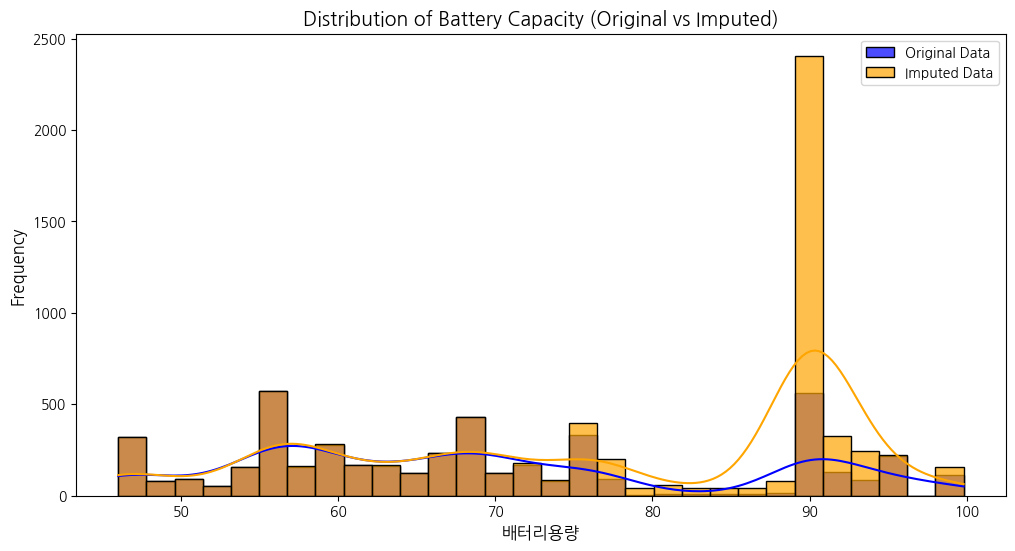

In [147]:
# 결측값이 채워진 데이터 불러오기
data_filled = pd.read_csv(path+'/open/encoded_train_filled.csv')

# 결측값이 없었던 데이터와 결측값이 채워진 데이터 분리
original_data = encoded_train[~encoded_train['배터리용량'].isnull()]  # 원래 결측값이 없었던 데이터
imputed_data = data_filled[~data_filled['배터리용량'].isnull()] # 결측값이 채워진 데이터

# 히스토그램 비교
plt.figure(figsize=(12, 6))

# 원본 데이터 히스토그램
sns.histplot(original_data['배터리용량'], bins=30, kde=True, color='blue', label='Original Data', alpha=0.7)

# 결측값 채워진 데이터 히스토그램
sns.histplot(imputed_data['배터리용량'], bins=30, kde=True, color='orange', label='Imputed Data', alpha=0.7)

plt.title('Distribution of Battery Capacity (Original vs Imputed)', fontsize=14)
plt.xlabel('배터리용량', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

- LightGBM:
    - 빈도가 비교적 자연스럽게 분포하며, Y축 값이 높은 것은 데이터가 더 고르게 예측되었음을 나타냅니다.
    - Imputed Data의 값이 Original Data와 잘 조화를 이루고 있습니다.
- KNN: 
    - Y축 값은 LightGBM보다 낮지만, 분포가 LightGBM만큼 자연스럽지 않고, 특정 구간에서 데이터가 몰리는 경향이 있습니다.

- **LightGBM**이 KNN보다 더 나은 선택으로 보입니다:   
    - LightGBM은 빈도가 높은 구간에서도 원본 데이터와의 조화를 더 잘 이루고 있습니다.
    - KNN은 특정 값에서 빈도가 감소하거나 몰리는 경향이 있어 데이터 분포가 불규칙적으로 보입니다.

### GridSearch로 LightGBM 하이퍼파라미터 튜닝

param_dist = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, -1],
    'num_leaves': [15, 31, 63],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=200,  # 랜덤 탐색 횟수
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)
random_search.fit(X_train, y_train)

이렇게 했는데도 RMSE 3.66 나오길래 하이퍼파라미터 튜닝 **포기**

### Test 데이터에 동일한 인코딩 적용

In [148]:
import pandas as pd

# 테스트 데이터 불러오기
test_data = pd.read_csv(path + '/open/test.csv')

# 원-핫 인코딩 대상 변수 (훈련 데이터와 동일)
one_hot_features = ['모델', '차량상태', '구동방식']

# 라벨 인코딩 대상 변수 (훈련 데이터와 동일)
label_encode_feature = '사고이력'

# 원-핫 인코딩 적용
encoded_one_hot_test = pd.DataFrame(
    one_hot_encoder.transform(test_data[one_hot_features]).astype(int),
    columns=one_hot_encoder.get_feature_names_out(one_hot_features)
)

# '사고이력'에 라벨 인코딩 적용
test_data[label_encode_feature] = label_encoder.transform(test_data[label_encode_feature])

# 원본 범주형 열 제거
test_data = test_data.drop(columns=one_hot_features)

# 인코딩된 열 병합
encoded_test_data = pd.concat([test_data, encoded_one_hot_test], axis=1)

# 결과 확인
print(encoded_test_data.head())

# CSV로 저장
encoded_test_data.to_csv(path + '/open/encoded_test.csv', index=False)
print("테스트 데이터가 'encoded_test.csv'로 저장되었습니다.")

         ID 제조사   배터리용량  주행거리(km)  보증기간(년)  사고이력  연식(년)  모델_ID4  모델_ION5  \
0  TEST_000  P사  76.093     14057        2     0      0       0        0   
1  TEST_001  B사  90.000      7547        8     0      0       0        0   
2  TEST_002  B사     NaN      7197        7     1      0       0        0   
3  TEST_003  H사  68.479     10357        7     0      1       0        1   
4  TEST_004  K사     NaN      7597       10     0      0       0        0   

   모델_ION6  ...  모델_TayCT  모델_TayGTS  모델_eT  모델_i3  모델_i5  모델_iX  \
0        0  ...         1          0      0      0      0      0   
1        0  ...         0          0      0      0      0      1   
2        0  ...         0          0      0      0      1      0   
3        0  ...         0          0      0      0      0      0   
4        0  ...         0          0      0      0      0      0   

   차량상태_Nearly New  차량상태_Pre-Owned  구동방식_FWD  구동방식_RWD  
0                1               0         0         0  
1                0  

### Test 배터리 용량 결측값 채우기 (회귀모델 훈련)

In [149]:
# 사용 변수 선택 (훈련 데이터와 동일)
features = ['보증기간(년)', '주행거리(km)', '차량상태_Pre-Owned']

# 결측값이 있는 데이터 준비
test_data_with_na = encoded_test_data[encoded_test_data['배터리용량'].isnull()].copy()
X_missing_test = test_data_with_na[features]
X_missing_test = X_missing_test.reindex(columns=X_train.columns, fill_value=0)

# 모델을 사용해 배터리용량 결측값 예측
test_data_with_na.loc[:, '배터리용량'] = model.predict(X_missing_test)

# 배터리용량이 채워진 데이터 결합
test_data_filled = pd.concat([encoded_test_data.dropna(subset=['배터리용량']), test_data_with_na])

# 채워진 데이터 저장
test_data_filled.to_csv(path + '/open/encoded_test_filled.csv', index=False)
print("encoded_test_filled.csv에 저장되었습니다.")

encoded_test_filled.csv에 저장되었습니다.


In [150]:
train_data_filled.describe()

,배터리용량,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),모델_ID4,모델_ION5,모델_ION6,모델_IONIQ,...,모델_TayCT,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD
count,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,...,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000
mean,76.346415,44287.979458,4.960918,0.045752,0.222489,62.331949,0.080699,0.047086,0.050554,0.018674,...,0.044685,0.050020,0.050554,0.051754,0.055222,0.048953,0.274643,0.274510,0.169001,0.141790
std,15.644378,55204.064386,3.155342,0.208960,0.569232,36.646759,0.272390,0.211836,0.219099,0.135380,...,0.206624,0.218001,0.219099,0.221545,0.228428,0.215784,0.446364,0.446297,0.374778,0.348858
min,46.000000,3.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,61.994000,5465.000000,2.000000,0.000000,0.000000,34.390000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,77.813720,17331.000000,5.000000,0.000000,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,90.056897,61252.000000,8.000000,0.000000,0.000000,80.050000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,99.800000,199827.000000,10.000000,1.000000,2.000000,161.090000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [151]:
test_data_filled.describe()

,배터리용량,주행거리(km),보증기간(년),사고이력,연식(년),모델_ID4,모델_ION5,모델_ION6,모델_IONIQ,모델_KNE,...,모델_TayCT,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD
count,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,...,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,75.490934,44664.152482,5.027187,0.056738,0.206856,0.080378,0.047281,0.050827,0.018913,0.048463,...,0.044917,0.049645,0.050827,0.052009,0.054374,0.048463,0.277778,0.275414,0.170213,0.144208
std,15.924994,55518.084064,3.157479,0.231477,0.544798,0.272039,0.212366,0.219775,0.136297,0.214870,...,0.207245,0.217340,0.219775,0.222177,0.226887,0.214870,0.448168,0.446987,0.376042,0.351508
min,46.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.485598,6156.500000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,75.145000,17254.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,91.078220,60141.250000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,99.800000,199948.000000,10.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


---

In [162]:
# 학습과 예측을 위해 데이터를 분리합니다.
x_train = train_data_filled.drop(['ID', '제조사', '모델(회사)', '가격(백만원)'], axis = 1)
y_train = train_data_filled['가격(백만원)']

x_test = test_data_filled.drop(['ID', '제조사'], axis = 1)

In [157]:
display(x_train.head(3))

,배터리용량,주행거리(km),보증기간(년),사고이력,연식(년),모델_ID4,모델_ION5,모델_ION6,모델_IONIQ,모델_KNE,...,모델_TayCT,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD
0,86.077,13642,0,0,2,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,56.000,10199,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,91.200,2361,7,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [163]:
display(x_test.head(3))

,배터리용량,주행거리(km),보증기간(년),사고이력,연식(년),모델_ID4,모델_ION5,모델_ION6,모델_IONIQ,모델_KNE,...,모델_TayCT,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD
0,76.093,14057,2,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,90.000,7547,8,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,68.479,10357,7,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [13]:
# # 범주형 변수에 대해 레이블 인코딩을 적용합니다.
# categorical_features = [col for col in x_train.columns if x_train[col].dtype == 'object']

# for i in categorical_features:
#     le = LabelEncoder()
#     le=le.fit(x_train[i]) 
#     x_train[i]=le.transform(x_train[i])
    
#     for case in np.unique(x_test[i]):
#         if case not in le.classes_: 
#             le.classes_ = np.append(le.classes_, case) 
#     x_test[i]=le.transform(x_test[i])
    
# display(x_train.head(3))

,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
0,4,16,1,86.077,0,13642,0,0,2
1,3,10,1,56.000,1,10199,6,0,0
2,0,17,0,91.200,0,2361,7,0,0


### 학습 및 예측하기

In [164]:
# 모델을 선언하고, 학습을 진행합니다.
model = DecisionTreeRegressor()
model.fit(x_train, y_train)

DecisionTreeRegressor()

In [165]:
# 예측을 수행합니다.
pred = model.predict(x_test)

### 제출하기

In [166]:
# sample_submission 파일을 불러옵니다.
submit = pd.read_csv(path+'/open/sample_submission.csv')

In [167]:
# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred
submit.head()

,ID,가격(백만원)
0,TEST_000,130.84
1,TEST_001,80.26
2,TEST_002,34.21
3,TEST_003,80.98
4,TEST_004,23.72


In [168]:
# 제출을 위해 baseline_submission.csv란 이름으로 CSV 파일을 저장합니다.
submit.to_csv(path+'/submission/240115-pred02.csv',index=False)